# Mushroom Classification Analysis

## Introduction
In this notebook, we will perform a comprehensive analysis of the
mushroom dataset to classify mushrooms as edible or poisonous.
We will use various machine learning models and employ feature
selection techniques to reduce the feature set while maintaining
high classification accuracy.

### Dataset Overview
- **Number of Instances**: 8124
- **Number of Attributes**: 22 (all categorical)
- **Target Variable**: `class` (edible or poisonous)
- **Missing Values**: 2480 missing values in the `stalk_root` attribute.

### Key Steps:
1. **Data Preprocessing**: Handle missing values, encode categorical
                           features, and split the data.
3. **Model Training**: Train multiple classification models and evaluate
                       their performance.
5. **Feature Importance Analysis**: Visualize feature importances from
                                    trained models.
7. **Feature Selection**: Use Recursive Feature Elimination (RFE),
                           Mutual Information,
                           and Chi-Square tests to identify the most
                           important features.
9. **Re-analysis**: Drop the `odor` feature and repeat the analysis to
                    see its impact on model performance.
11. **Conclusion**: Summarize findings and identify the minimal feature
                    set for perfect classification.

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [4]:
from tools import rename_columns

## Data Preprocessing

##### Mushroom Database

Below are the information extracted from the file 'agaricus-lepiota.names'.

- Number of Instances: 8124

- Number of Attributes: 22 (all nominally valued)

* Attribute Information: (classes: edible=e, poisonous=p)
    1. **cap-shape**: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s  
    2. **cap-surface**: fibrous=f, grooves=g, scaly=y, smooth=s  
    3. **cap-color**: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y  
    4. **bruises?**: bruises=t, no=f  
    5. **odor**: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s  
    6. **gill-attachment**: attached=a, descending=d, free=f, notched=n  
    7. **gill-spacing**: close=c, crowded=w, distant=d  
    8. **gill-size**: broad=b, narrow=n  
    9. **gill-color**: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y  
    10. **stalk-shape**: enlarging=e, tapering=t  
    11. **stalk-root**: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?  
    12. **stalk-surface-above-ring**: fibrous=f, scaly=y, silky=k, smooth=s  
    13. **stalk-surface-below-ring**: fibrous=f, scaly=y, silky=k, smooth=s  
    14. **stalk-color-above-ring**: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y  
    15. **stalk-color-below-ring**: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y  
    16. **veil-type**: partial=p, universal=u  
    17. **veil-color**: brown=n, orange=o, white=w, yellow=y  
    18. **ring-number**: none=n, one=o, two=t  
    19. **ring-type**: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z  
    20. **spore-print-color**: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y  
    21. **population**: abundant=a, clustered=c, numerous=n, scattered=s, several=v
    22. **habitat**: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d  

- Missing Attribute Values: 2480 of them (denoted by "?"), all for attribute #11.

* Class Distribution:
    - **edible**: 4208 (51.8%)
    - **poisonous**: 3916 (48.2%)
    - **total**: 8124 instances

### Data Collection

#### Read the data from the csv file

In [5]:
# reading the raw CSV data file
csv_df = pd.read_csv("./Code/Data/mushroom/agaricus-lepiota.data")
csv_df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


#### Let's replace the 'encoded' feature names with the full names.

In [6]:
# Rename columns
original_csv_df = csv_df.copy()
csv_df = rename_columns(csv_df)

In [7]:
csv_df.shape

(8123, 23)

#### Let's confirm that all missing values are in column 11

In [8]:
# finding columns in the df which have any null/na values
csv_df.replace('?', np.nan, inplace=True)
np.where(pd.isna(csv_df))

(array([3983, 4022, 4075, ..., 8120, 8121, 8122]),
 array([11, 11, 11, ..., 11, 11, 11]))

In [9]:
# Checking the missing values
series = csv_df.isnull().sum()
non_zero_lines = series[series != 0]

print(non_zero_lines)

stalk_root    2480
dtype: int64


In [10]:
csv_df = csv_df.drop_duplicates()
csv_df.shape

(8123, 23)

In [11]:
# getting unique values from each column, so we know which values to convert to numerical
for col in csv_df.columns:
    print(col, csv_df[col].unique())

class ['e' 'p']
cap_shape ['x' 'b' 's' 'f' 'k' 'c']
cap_surface ['s' 'y' 'f' 'g']
cap_color ['y' 'w' 'g' 'n' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['a' 'l' 'p' 'n' 'f' 'c' 'y' 's' 'm']
gill_attachment ['f' 'a']
gill_spacing ['c' 'w']
gill_size ['b' 'n']
gill_color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk_shape ['e' 't']
stalk_root ['c' 'e' 'b' 'r' nan]
stalk_surface_above_ring ['s' 'f' 'k' 'y']
stalk_surface_below_ring ['s' 'f' 'y' 'k']
stalk_color_above_ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk_color_below_ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil_type ['p']
veil_color ['w' 'n' 'o' 'y']
ring_number ['o' 't' 'n']
ring_type ['p' 'e' 'l' 'f' 'n']
spore_print_color ['n' 'k' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['n' 's' 'a' 'v' 'y' 'c']
habitat ['g' 'm' 'u' 'd' 'p' 'w' 'l']


##### Drop the column 'veil_type' since it as only one value 'p'.

In [12]:
csv_df = csv_df.drop('veil_type', axis=1)

#### Let's remove the feature 'stalk-root' from the data.

In [13]:
csv_df = csv_df.drop('stalk_root', axis=1)
csv_df

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,s,w,w,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,s,o,o,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,s,o,o,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,s,o,o,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,s,k,w,w,w,o,e,w,v,l


In [14]:
# Calculate the value counts
counts = csv_df['class'].value_counts()

# Calculate the ratio
total_count = counts.sum()  # Total number of rows
ratios = counts / total_count

# Combine counts and ratios into a DataFrame
result = pd.DataFrame({'Count': counts, 'Ratio': ratios})

# Display the result
print(result)

       Count     Ratio
class                 
e       4208  0.518035
p       3915  0.481965


In [15]:
X = csv_df.drop(['class'],axis=1)
Y = csv_df['class']

In [16]:
# Let's transform 'e' and 'p' into 1 and 0 respectively so
# that precision is the score we want to maximize.
class_dict ={'e':1, 'p':0}
Y_onehot = Y.map(class_dict)

#### **Limited Number of Directly Observable Features**

We are going to use a limited number of features that have the
highest 'Mutual Information' value among the visual features that
are directly observable when handling a mushroom.

(see Jupyter notebook `mushrooms_classification.ipynb` for more details)


In [17]:
# List of features
filtered_features = ['spore_print_color', 'stalk_surface_above_ring', 'ring_type',
       'gill_color', 'stalk_surface_below_ring', 'gill_size', 'bruises',
       'stalk_color_above_ring', 'stalk_color_below_ring', 'gill_spacing',
       'cap_color', 'cap_shape', 'ring_number']#, 'veil_color']

# Filter the features and target
X_filtered = X[filtered_features]

# creating train/test split using 65% data for training and 35% for testing
(X_filtered_train,
 X_filtered_test,
 y_filtered_train,
 y_filtered_test) = train_test_split(X_filtered, Y_onehot,
                                     test_size = 0.35,
                                     random_state = 42)
# Initialize the OneHotEncoder
preprocessor = OneHotEncoder(sparse_output=False)

# Apply preprocessing and convert back to DataFrame
X_filtered_train = pd.DataFrame(preprocessor.fit_transform(X_filtered_train),
                                columns=preprocessor.get_feature_names_out())
X_filtered_test = pd.DataFrame(preprocessor.transform(X_filtered_test),
                               columns=preprocessor.get_feature_names_out())


In [18]:
def custom_precision_loss(beta=1.0, threshold=0.5):
    """
    Creates a custom loss function that combines Binary Cross-Entropy (BCE)
    with a precision penalty.

    Parameters:
    -----------
    beta : float, optional
        The weight of the precision penalty in the loss function.
        A higher value places more emphasis on improving precision.
        Default is 1.0.
    threshold : float, optional
        The decision threshold for converting predicted probabilities to binary
        predictions. A higher threshold increases precision by making the model
        more conservative. Default is 0.5.

    Returns:
    --------
    function
        A loss function that takes `y_true` (true labels) and `y_pred`
        (predicted probabilities) as inputs and returns a scalar loss value.
    """
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        y_pred_class = tf.cast(y_pred >= threshold, tf.float32)  # Custom threshold
        true_positives = tf.reduce_sum(y_true * y_pred_class)
        predicted_positives = tf.reduce_sum(y_pred_class)
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        precision_penalty = 1 - precision
        return bce + beta * precision_penalty
    return loss

# Callback to track the best epoch
class BestEpochTracker(Callback):
    def __init__(self):
        super(BestEpochTracker, self).__init__()
        self.best_epoch = 0
        self.best_value = None

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get('val_precision')  # Monitor validation precision
        if self.best_value is None or current_value > self.best_value:
            self.best_value = current_value
            self.best_epoch = epoch + 1  # Epochs are 0-indexed

In [19]:
# Split data for training and validation
X_nn_test, y_nn_test = X_filtered_test, y_filtered_test
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    X_filtered_train, y_filtered_train, test_size=0.2, random_state=42
)


In [20]:
# Build the model
model = Sequential([
    Input(shape=(X_nn_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with beta = 0.5 and threshold = 0.6
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=custom_precision_loss(beta=0.5, threshold=0.6),
              metrics=['accuracy', 'precision'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,049 (23.63 KB)

 Trainable params: 6,049 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_precision',
                               patience=5, mode='max',
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras',
                                   monitor='val_precision',
                                   save_best_only=True,
                                   mode='max')
best_epoch_tracker = BestEpochTracker()

# Train the model
history = model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, best_epoch_tracker]
)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8544 - loss: 0.5107 - precision: 0.8083 - val_accuracy: 0.9451 - val_loss: 0.1504 - val_precision: 0.9306
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9665 - loss: 0.1090 - precision: 0.9689 - val_accuracy: 0.9706 - val_loss: 0.0710 - val_precision: 0.9852
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9831 - loss: 0.0496 - precision: 0.9914 - val_accuracy: 0.9830 - val_loss: 0.0452 - val_precision: 0.9908
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9882 - loss: 0.0348 - precision: 0.9954 - val_accuracy: 0.9858 - val_loss: 0.0395 - val_precision: 0.9787
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9929 - loss: 0.0217 - precision: 0.9962 - val_accuracy: 0.9905 - val_loss: 0.0235 - val_precision: 0.9945
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9938 - loss: 0.0191 - precision: 0.9964 - val_accuracy: 0.9934 - val_loss

In [22]:
# Load the best model
best_model = load_model('best_model.keras',
                        custom_objects={'custom_precision_loss': custom_precision_loss(beta=2.0)})

# Evaluate the best model
loss, accuracy, precision = best_model.evaluate(X_nn_test, y_nn_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")

# Print the best epoch
print(f"Best model saved at epoch: {best_epoch_tracker.best_epoch}")


Test Loss: 0.0069
Test Accuracy: 0.9986
Test Precision: 1.0000
Best model saved at epoch: 9


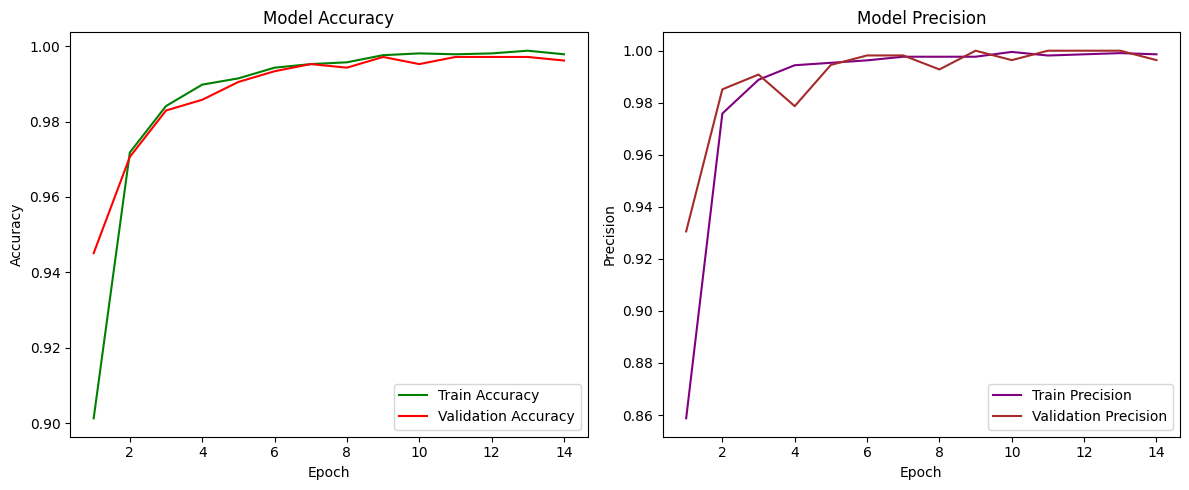

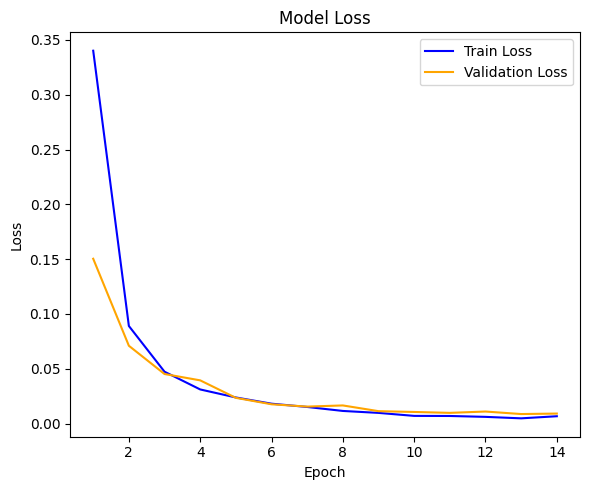

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure for accuracy and precision
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Train Accuracy', color='green')
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(history.history['precision']) + 1), y=history.history['precision'], label='Train Precision', color='purple')
sns.lineplot(x=range(1, len(history.history['val_precision']) + 1), y=history.history['val_precision'], label='Validation Precision', color='brown')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

# Create a separate figure for loss
plt.figure(figsize=(6, 5))

# Plot Loss
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()